In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px
from sklearn.model_selection import train_test_split
from fastai.tabular import FillMissing, Categorify, Normalize, TabularList, tabular_learner, accuracy, roc_curve, ShowGraph, DatasetType
from sklearn.metrics import make_scorer, roc_curve, f1_score, roc_auc_score, accuracy_score, classification_report, confusion_matrix, balanced_accuracy_score
from sklearn.metrics import ConfusionMatrixDisplay, RocCurveDisplay, PrecisionRecallDisplay, precision_recall_curve

from sklearn.impute import SimpleImputer
import warnings
warnings.filterwarnings('ignore')

In [3]:
df = pd.read_csv("https://github.com/bitsbuffer/mlhw1/raw/master/dataset/train.csv.zip", compression="zip")
train, test = train_test_split(df, train_size=0.7)

In [10]:
# Function to convert to hexavigesimal base
def az_to_int(az, nanVal=None):
    if az==az:  #catch NaN
        hv = 0
        for i in range(len(az)):
            hv += (ord(az[i].lower())-ord('a')+1)*26**(len(az)-1-i)
        return hv
    else:
        if nanVal is not None:
            return nanVal
        else:
            return az

In [11]:
def clean_data(df, cat_cols):
    df.v22 = df.v22.apply(az_to_int)
    df.drop(columns='ID', inplace=True)
    for cat_col in cat_cols:
        df[cat_col].fillna("__MISS__", inplace=True)
    return df

In [12]:
cat_cols = train.select_dtypes(include=['object']).columns.tolist()
cat_cols.remove('v22')
train = clean_data(train, cat_cols)
test = clean_data(test, cat_cols)
cont_cols = train.select_dtypes(include=['float', 'int']).columns.tolist()

In [13]:
procs = [FillMissing, Categorify, Normalize]
test_data = TabularList.from_df(test, path=".", cat_names=cat_cols, cont_names=cont_cols, procs=procs)
train_data = (TabularList.from_df(train, 
                                path='.', 
                                cat_names=cat_cols, 
                                cont_names=cont_cols, 
                                procs=procs)
                        .split_by_rand_pct(valid_pct=0.2, seed=1234)
                        .label_from_df(cols = 'target')
                        .add_test(test_data)
                        .databunch())

epoch,train_loss,valid_loss,accuracy,time
0,0.002816,0.001529,0.999938,00:40
1,0.001434,0.000158,1.000000,00:41
2,0.000352,0.000038,1.000000,00:42
3,0.000001,0.000000,1.000000,00:38
4,0.000002,0.000000,1.000000,00:40
5,0.000583,0.000012,1.000000,00:40
6,0.001882,0.000217,0.999938,00:40
7,0.000000,0.000000,1.000000,00:39
8,0.000000,0.000000,1.000000,00:40
9,0.000000,0.000000,1.000000,00:38


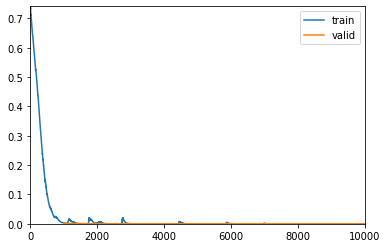

CPU times: user 6min 29s, sys: 13.2 s, total: 6min 42s
Wall time: 6min 44s


In [31]:
%%time
learn = tabular_learner(train_data, layers=[64, 32, 16], metrics=accuracy, callback_fns=ShowGraph)
learn.fit_one_cycle(10)

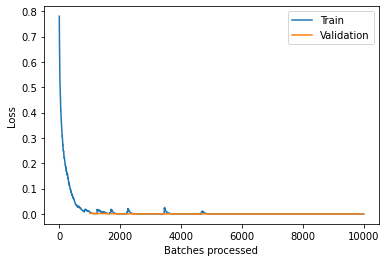

In [15]:
learn.recorder.plot_losses()

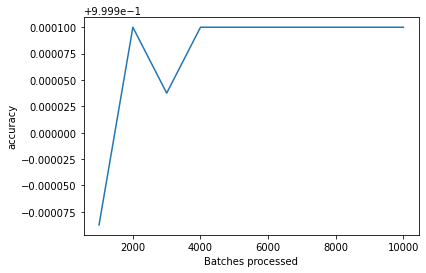

In [16]:
learn.recorder.plot_metrics()

In [32]:
yhat_test_tensor = learn.get_preds(ds_type=DatasetType.Test)[1]
yhat_test = yhat_test_tensor.numpy()

In [33]:
def print_classification_report(y_test, yhat_test):
    cm = confusion_matrix(y_test, yhat_test)
    print("********************************************************")
    print("Accuracy on Test data ", accuracy_score(y_test, yhat_test))
    print("********************************************************")
    print("F1 on Test data ", f1_score(y_test, yhat_test))
    print("********************************************************")
    print("AUC ROC on Test data ", roc_auc_score(y_test, yhat_test))
    print("********************************************************")
    print(classification_report(y_test, yhat_test))
    print("********************************************************")
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(18, 6))
    cm = confusion_matrix(y_test, yhat_test)
    print(cm)

********************************************************
Accuracy on Test data  0.2410123334402426
********************************************************
F1 on Test data  0.0
********************************************************
AUC ROC on Test data  0.5
********************************************************
              precision    recall  f1-score   support

           0       0.24      1.00      0.39      8266
           1       0.00      0.00      0.00     26031

    accuracy                           0.24     34297
   macro avg       0.12      0.50      0.19     34297
weighted avg       0.06      0.24      0.09     34297

********************************************************
[[ 8266     0]
 [26031     0]]


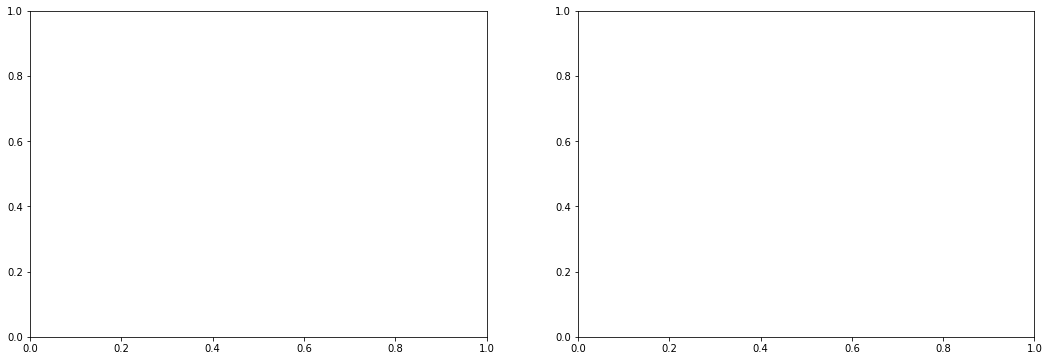

In [30]:
print_classification_report(y_test, yhat_test) 